# Australia pricing prediction (Liner Regression and Hypothesis Testing)

## Author: Yuanying Li

#Part 1a - Import necessary packages#

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
rcParams['figure.figsize'] = (23, 8)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Part 1b - Acquire data and perform light modifications#


* For this part, it is dataset about Australia rent price
and there are several features that we do not need, such as 'id', 'country', 'state', so we can drop them.


* The actual path to a downloadable CSV is:https://docs.google.com/spreadsheets/d/e/2PACX-1vSp5g_BQzUosQ6O94J5DKt11UFEscjn4DvFJ9nk4r2AcMc6QhARgqbGQC7bCP_qraY_iOveUPBenWsu/pub?output=csv

In [0]:
#Read data from Google Sheet
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSp5g_BQzUosQ6O94J5DKt11UFEscjn4DvFJ9nk4r2AcMc6QhARgqbGQC7bCP_qraY_iOveUPBenWsu/pub?output=csv"
australia_df = pd.read_csv(data_path)

#Drop extraneous columns
try:
    australia_df = australia_df.drop(columns = ['id', 'country', 'state'])
except KeyError:
  print ("Note: Either the columns were not found or already dropped.")

#Remove the symbol '\$':'',',':'' in price column
#Convert price's data type from string to int
australia_df['price'] = australia_df['price'].replace(to_replace={'\$':'',',':''}, regex=True).astype(float).astype(int)


#Trim outliers:
starting_percentile = australia_df['price'].quantile(.01)
ending_percentile = australia_df['price'].quantile(.99)
australia_price_outliers_df = australia_df.loc[((australia_df['price'] <= starting_percentile) | (australia_df['price'] >= ending_percentile))]
australia_df_trimmed = australia_df.loc[((australia_df['price'] > starting_percentile) & (australia_df['price'] < ending_percentile))]

#Drop incomplete cases (those cases where price was null)
australia_df_filtered = australia_df_trimmed.dropna()

#Show the final dataset
australia_df_filtered.head()



,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
0,BALLINA SHIRE COUNCIL,House,0.00,2900,Entire home/apt,3.0,4.0,4.0
2,BALLINA SHIRE COUNCIL,Guest suite,15.00,141,Entire home/apt,1.0,1.0,1.0
8,BALLINA SHIRE COUNCIL,House,18.79,65,Private room,1.0,1.0,1.0
10,BALLINA SHIRE COUNCIL,House,18.52,60,Private room,1.0,1.0,1.0
11,BALLINA SHIRE COUNCIL,House,16.74,60,Private room,1.0,1.0,1.0


**Column list:**

* neighbourhood_cleansed - A modified version of the neighborhood that can be used for grouping.
* property_type - The type of property that is being listed.
* room_type - The type of room that is available for rent.
* bathrooms - The count of bathrooms available. 
* bedrooms - The count of bedrooms available.
* beds - The count of beds available in the rental.
* price - The cost of the rental per night in USD.
* square_meters - The area of a house.

#Part 1c - Describe quantitative variables

In [0]:
australia_df_filtered.describe()

,square_meters,price,bathrooms,bedrooms,beds
count,3886.000000,3886.000000,3886.000000,3886.000000,3886.000000
mean,32.717774,761.844056,1.628024,2.257591,2.983016
std,12.382193,732.176936,0.814059,1.355208,1.972715
min,0.000000,53.000000,0.000000,0.000000,0.000000
25%,24.902500,200.000000,1.000000,1.000000,1.000000
50%,29.740000,510.000000,1.000000,2.000000,3.000000
75%,35.010000,1089.750000,2.000000,3.000000,4.000000
max,208.700000,4000.000000,9.000000,12.000000,18.000000


#Part 1d - Describe qualitative variables

In [0]:
australia_df_filtered[['neighbourhood_cleansed','property_type', 'room_type']].describe()

,neighbourhood_cleansed,property_type,room_type
count,3886,3886,3886
unique,5,8,3
top,BYRON SHIRE COUNCIL,House,Entire home/apt
freq,2440,2348,3178


#Part 2a - Describe Regression approach#

* Fistly, let's assume the square meter is related to the price, here is the regression formula as follows.

yˆ=θ0+θ1x1+θ2x2+⋯+θnxn

In [0]:
#To explore what are the contents in neighbourhood_cleansed column.
list(set(australia_df_filtered["neighbourhood_cleansed"]))

['LISMORE CITY COUNCIL',
 'TWEED SHIRE COUNCIL',
 'BALLINA SHIRE COUNCIL',
 'BYRON SHIRE COUNCIL',
 'RICHMOND VALLEY COUNCIL']

{'LISMORE CITY COUNCIL': 'red', 'TWEED SHIRE COUNCIL': 'yellow', 'BALLINA SHIRE COUNCIL': 'blue', 'BYRON SHIRE COUNCIL': 'green', 'RICHMOND VALLEY COUNCIL': 'black'}
LISMORE CITY COUNCIL {'LISMORE CITY COUNCIL': 'red'}
TWEED SHIRE COUNCIL {'TWEED SHIRE COUNCIL': 'yellow'}
BALLINA SHIRE COUNCIL {'BALLINA SHIRE COUNCIL': 'blue'}
BYRON SHIRE COUNCIL {'BYRON SHIRE COUNCIL': 'green'}
RICHMOND VALLEY COUNCIL {'RICHMOND VALLEY COUNCIL': 'black'}


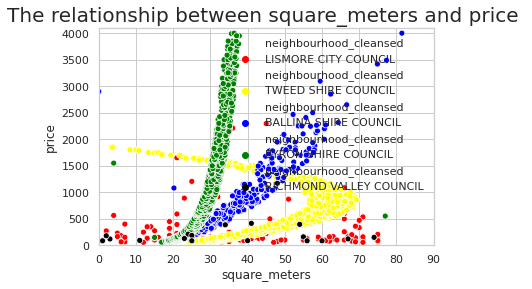

In [0]:
#Define a method to extract dataset in neighbourhood_cleansed column and draw a scatterplot.
sns.set_style('whitegrid')
def do(district, pair):
  indexes = australia_df_filtered["neighbourhood_cleansed"] == district
  grpu_data = australia_df_filtered[indexes]
  ax = sns.scatterplot(x = 'square_meters', y = 'price', hue="neighbourhood_cleansed",
                data=grpu_data, palette=pair)
plt.xlim([0,90])
plt.ylim([0,4100])
plt.title('The relationship between square_meters and price ',fontsize=20)
districts =list(set(australia_df_filtered["neighbourhood_cleansed"]))
plates = {}
colors = ["red","yellow", "blue", "green", "black"]
for i in range(len(districts)):
  district = districts[i]
  color = colors[i]
  plates[district] = color
print(plates)
rcParams['figure.figsize'] = (23, 8)

for district in districts:
  print(district, {district: plates[district]})
  do(district, {district: plates[district]})

### obviouly, the dataset of Richmond valley council ,Lismore city council are not easy to analyze, so we can focus on the other Three areas (Ballina shire council, Byron shire counciland Tweed shire council).

#Part 2b - Regression approach 1 - Ballina shire council.#

In [0]:
#Perform a dataset to focus on Ballina shire council area and select a specific area.
australia_df_coucil1 = australia_df_filtered.loc[(australia_df_filtered['neighbourhood_cleansed'].isin(['BALLINA SHIRE COUNCIL']))]
australia_df_coucil1 = australia_df_coucil1.loc[(australia_df_coucil1['property_type'].isin(['House']))]
australia_df_coucil1 = australia_df_coucil1.loc[(australia_df_coucil1['room_type'] == 'Entire home/apt')]
print(australia_df_coucil1.shape)
australia_df_coucil1.head()



(200, 8)


,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
0,BALLINA SHIRE COUNCIL,House,0.00,2900,Entire home/apt,3.0,4.0,4.0
30,BALLINA SHIRE COUNCIL,House,18.40,75,Entire home/apt,1.0,2.0,2.0
48,BALLINA SHIRE COUNCIL,House,19.15,89,Entire home/apt,1.0,1.0,1.0
51,BALLINA SHIRE COUNCIL,House,20.86,105,Entire home/apt,2.0,3.0,3.0
63,BALLINA SHIRE COUNCIL,House,22.94,136,Entire home/apt,1.0,1.0,1.0


## Part 2c - Regression line graph - Ballina shire council

Text(0.5, 1.0, 'The relationship between square_meters and price in Ballina shire council')

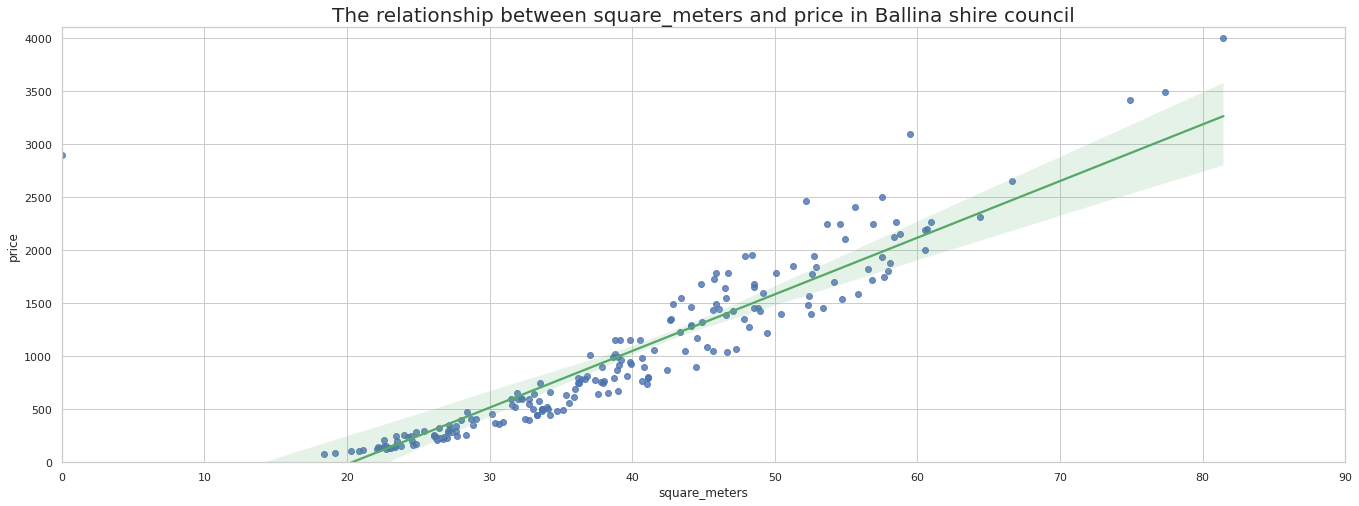

In [0]:
#plotting replot with Seaborn in Ballina shire council
sns.set_style('whitegrid')
ax = sns.regplot(x = 'square_meters', y = 'price', data = australia_df_coucil1,scatter_kws = {'color': 'b'}, line_kws = {'color': 'g'})
plt.xlim([0,90])
plt.ylim([0,4100])
plt.title('The relationship between square_meters and price in Ballina shire council',fontsize = 20)

## Part 2d - Fit a line with Sci-Kit Learn - Ballina shire council

In [0]:
X_cols = ['square_meters']

#Load the X data set
X = australia_df_coucil1[X_cols].values

#Initialize the data and column length variables
data_length = len(australia_df_coucil1)
column_length = len(australia_df_coucil1[X_cols].columns)
print(column_length)
#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = australia_df_coucil1['price'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

#Create the linear regression object and train/fit models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Make predictions using the testing set
listing_y_pred = lin_reg.predict(X_test)

1


##Take the results from above and print out a few pieces of information##

In [0]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg.intercept_))

#Print the coefficient(s)
coeff_df = pd.DataFrame(lin_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0   1500.420071
1    733.563299
2   1737.373110
3   2002.324977
4   1214.209836

Intercept: -1032.4368124762677
   square_meters
0       51.84968

Mean Squared Error (MSE):54695.14
Variance Score (R^2):0.91


## according to the result, Mean Squared Error(MSE) is big, and Variance Score approximately equals to 1, so the training maybe overfit. We can divide the data more specifically.

##Re-plot the graph using the results from Scikit-Learn##

Text(0.5, 1.0, 'The relationship between square_meters and price in Ballina shire council new')

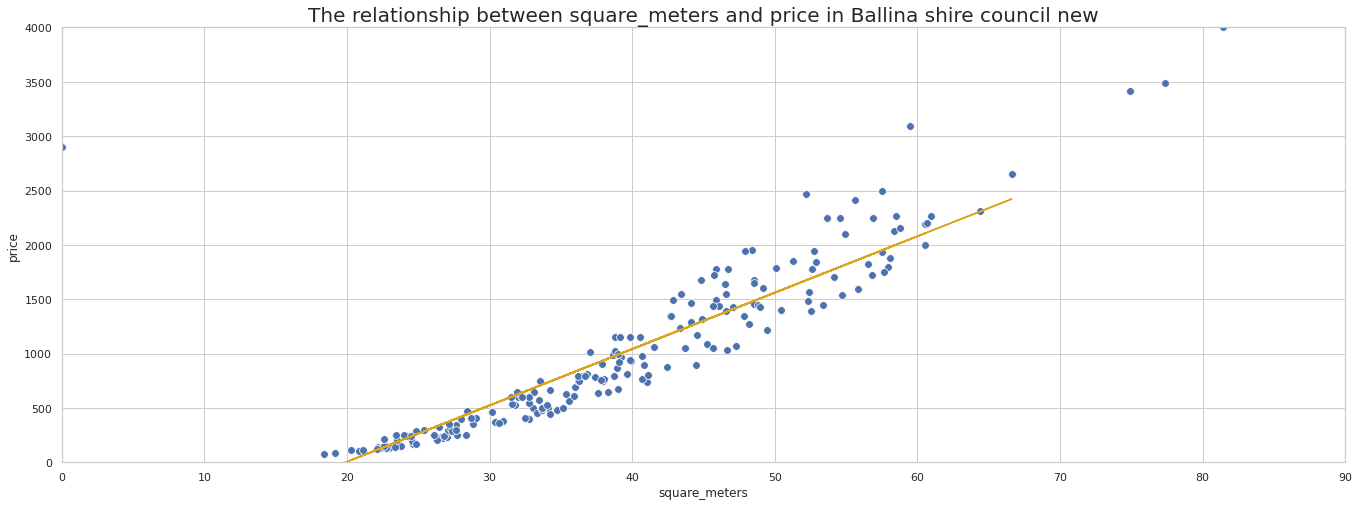

In [0]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = australia_df_coucil1, s=60)
plt.plot(X_test, listing_y_pred, color='goldenrod')
plt.xlim([0,90])
plt.ylim([0,4000])
plt.title('The relationship between square_meters and price in Ballina shire council new',fontsize = 20)

#Part 2e - Intepret the results#

\begin{multline*}
Price \approx intercept + coefficient_1 * synthetic\_sqft + e
\end{multline*}

so

y = -954 + 50.38 * x

#Part 3 - Regression approach 2 - BYRON SHIRE COUNCIL#

In [0]:
#Perform a dataset to focus on  BYRON SHIRE COUNCIL.
australia_df_coucil2 = australia_df_filtered.loc[(australia_df_filtered['neighbourhood_cleansed'].isin(['BYRON SHIRE COUNCIL']))]
australia_df_coucil2 = australia_df_coucil2.loc[(australia_df_coucil2['property_type'].isin(['House']))]
australia_df_coucil2 = australia_df_coucil2.loc[(australia_df_coucil2['room_type'] == 'Entire home/apt')]
print(australia_df_coucil2.shape)
australia_df_coucil2.head()

(1204, 8)


,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
453,BYRON SHIRE COUNCIL,House,4.00,1550,Entire home/apt,2.0,3.0,3.0
580,BYRON SHIRE COUNCIL,House,18.33,85,Entire home/apt,1.0,0.0,1.0
586,BYRON SHIRE COUNCIL,House,19.17,79,Entire home/apt,1.0,0.0,1.0
594,BYRON SHIRE COUNCIL,House,21.00,100,Entire home/apt,1.5,3.0,4.0
639,BYRON SHIRE COUNCIL,House,20.81,115,Entire home/apt,1.0,2.0,2.0


## Part 3a - Regression line graph - BYRON SHIRE COUNCIL

Text(0.5, 1.0, 'The relationship between square_meters and price in BYRON SHIRE COUNCIL')

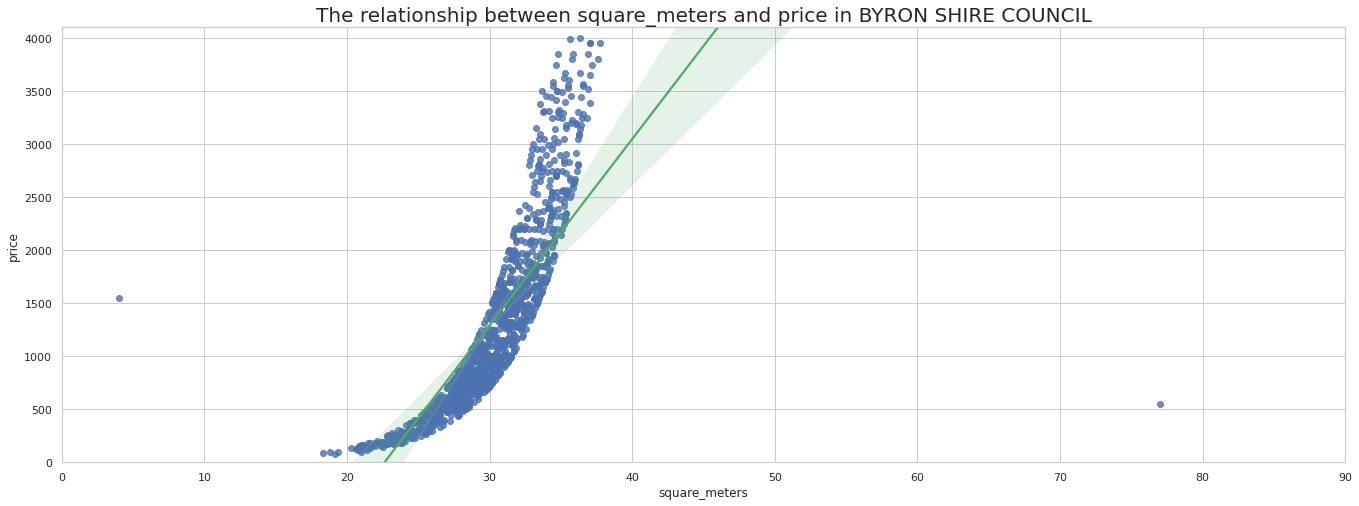

In [0]:
#plotting replot with Seaborn in BYRON SHIRE COUNCIL
sns.set_style('whitegrid')
ax = sns.regplot(x = 'square_meters', y = 'price', data = australia_df_coucil2,scatter_kws = {'color': 'b'}, line_kws = {'color': 'g'})
plt.xlim([0,90])
plt.ylim([0,4100])
plt.title('The relationship between square_meters and price in BYRON SHIRE COUNCIL',fontsize = 20)

## Part 3b - Fit a line with Sci-Kit Learn - BYRON SHIRE COUNCIL

In [0]:
X_cols2 = ['square_meters']

#Load the X data set
X2 = australia_df_coucil2[X_cols2].values

#Initialize the data and column length variables
data_length = len(australia_df_coucil2)
column_length = len(australia_df_coucil2[X_cols2].columns)

#Reshape and load remaining data sets
X2 = X2.reshape(data_length,column_length)
y2 = australia_df_coucil2['price'].values
y2 = y2.reshape(data_length,1)

#Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2)

#Create the linear regression object and train/fit models
lin_reg2 = LinearRegression()
lin_reg2.fit(X2_train, y2_train)

#Make predictions using the testing set
listing_y2_pred = lin_reg2.predict(X2_test)

##Take the results from above and print out a few pieces of information##

In [0]:
#Print a few predictions
print((pd.DataFrame(listing_y2_pred, columns={'y2_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg2.intercept_))

#Print the coefficient(s)
coeff_df2 = pd.DataFrame(lin_reg2.coef_)
coeff_df2.columns = X_cols2
print(coeff_df2)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y2_test, listing_y2_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y2_test, listing_y2_pred))

   y2_prediction
0    1140.918057
1    1796.464881
2     719.209582
3    1984.335007
4    2725.822421

Intercept: -4703.042044395112
   square_meters
0     199.861837

Mean Squared Error (MSE):498747.33
Variance Score (R^2):0.35


## Also, the variance score approximately equals to 1 and MSE is very big, the dataset train maybe overfit.

##Re-plot the graph using the results from Scikit-Learn##

Text(0.5, 1.0, 'The relationship between square_meters and price in BYRON SHIRE COUNCIL')

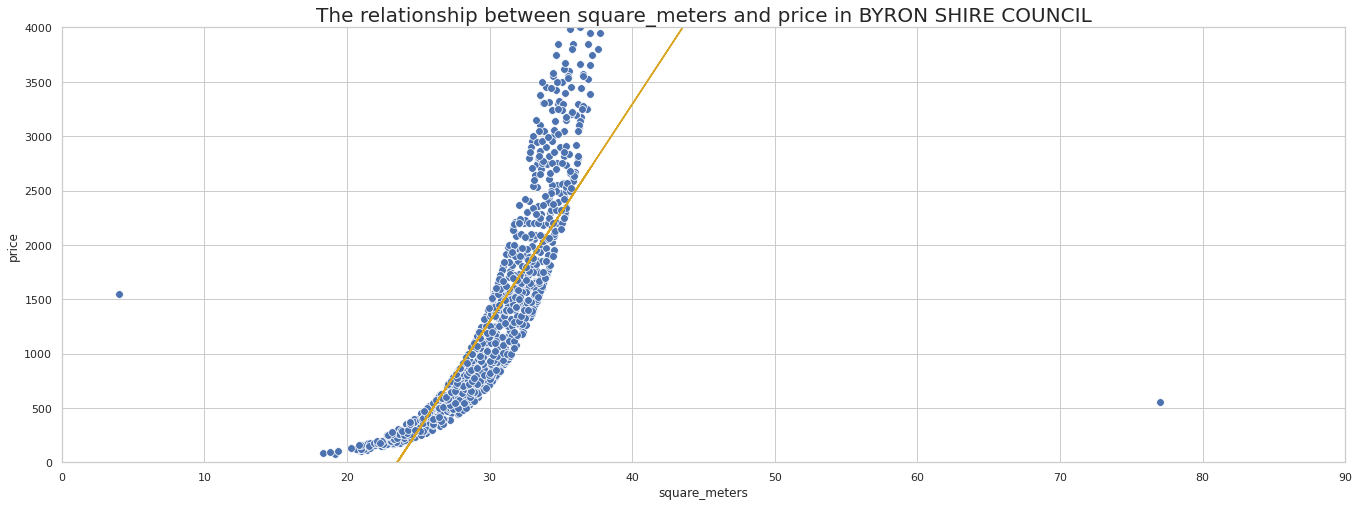

In [0]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = australia_df_coucil2, s=60)
plt.plot(X2_test, listing_y2_pred, color='goldenrod')
plt.xlim([0,90])
plt.ylim([0,4000])
plt.title('The relationship between square_meters and price in BYRON SHIRE COUNCIL',fontsize = 20)

#Part 3c - Intepret the results#

\begin{multline*}
Price \approx intercept + coefficient_1 * synthetic\_sqft + e
\end{multline*}

y = -4030 + 177x 

## Part 4 - Regression approach 1 - TWEED SHIRE COUNCIL.

In [0]:
#Perform a dataset to focus on TWEED SHIRE COUNCIL area.
australia_df_coucil3 = australia_df_filtered.loc[(australia_df_filtered['neighbourhood_cleansed'].isin(['TWEED SHIRE COUNCIL']))]
australia_df_coucil3 = australia_df_coucil3.loc[(australia_df_coucil3['property_type'].isin(['House']))]
australia_df_coucil3 = australia_df_coucil3.loc[(australia_df_coucil3['room_type'] == 'Entire home/apt')]
print(australia_df_coucil3.shape)
australia_df_coucil3.head()

(334, 8)


,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
3094,TWEED SHIRE COUNCIL,House,3.65,1850,Entire home/apt,3.0,4.0,6.0
3095,TWEED SHIRE COUNCIL,House,3.44,1850,Entire home/apt,4.0,5.0,5.0
3096,TWEED SHIRE COUNCIL,House,3.67,1851,Entire home/apt,2.5,4.0,5.0
3097,TWEED SHIRE COUNCIL,House,8.84,1800,Entire home/apt,2.5,5.0,7.0
3098,TWEED SHIRE COUNCIL,House,8.65,1800,Entire home/apt,3.0,6.0,6.0


## Part 4 - Regression line graph - TWEED SHIRE COUNCILL

Text(0.5, 1.0, 'The relationship between square_meters and price in TWEED SHIRE COUNCILL')

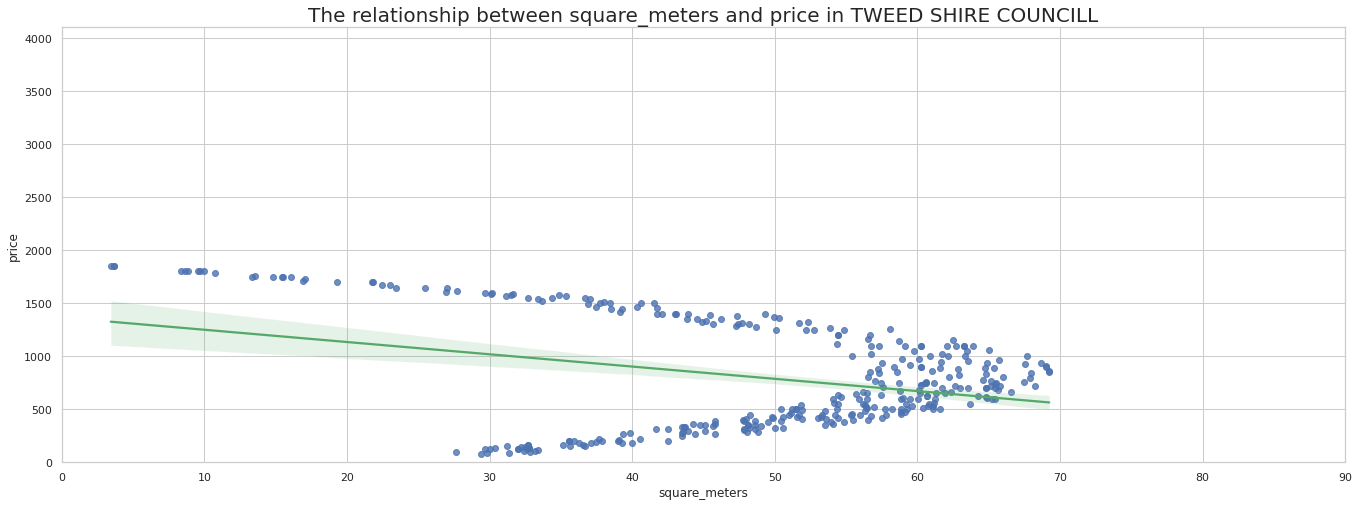

In [0]:
#plotting replot with Seaborn in TWEED SHIRE COUNCILL
sns.set_style('whitegrid')
ax = sns.regplot(x = 'square_meters', y = 'price', data = australia_df_coucil3,scatter_kws = {'color': 'b'}, line_kws = {'color': 'g'})
plt.xlim([0,90])
plt.ylim([0,4100])
plt.title('The relationship between square_meters and price in TWEED SHIRE COUNCILL',fontsize = 20)

## Part 4 - Fit a line with Sci-Kit Learn - TWEED SHIRE COUNCILL

In [0]:
X3_cols = ['square_meters']

#Load the X data set
X3 = australia_df_coucil3[X3_cols].values

#Initialize the data and column length variables
data_length = len(australia_df_coucil3)
column_length = len(australia_df_coucil3[X3_cols].columns)

#Reshape and load remaining data sets
X3 = X3.reshape(data_length,column_length)
y3 = australia_df_coucil3['price'].values
y3 = y3.reshape(data_length,1)

#Split the data into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3)

#Create the linear regression object and train/fit models
lin_reg3 = LinearRegression()
lin_reg3.fit(X3_train, y3_train)

#Make predictions using the testing set
listing_y3_pred = lin_reg3.predict(X3_test)

##Take the results from above and print out a few pieces of information##

## Re-plot the graph using the results from Scikit-Learn

In [0]:
#Print a few predictions
print((pd.DataFrame(listing_y3_pred, columns={'y3_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg3.intercept_))

#Print the coefficient(s)
coeff_df3 = pd.DataFrame(lin_reg3.coef_)
coeff_df3.columns = X3_cols
print(coeff_df3)
print()

#Performance Metric: Mean Squared Error
print(y3_test.shape, listing_y3_pred.shape)
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y3_test, listing_y3_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y3_test, listing_y3_pred))

   y3_prediction
0     754.286931
1     580.497876
2     792.543850
3     992.692856
4     710.198164

Intercept: 1344.5865317467583
   square_meters
0     -11.663695

(84, 1) (84, 1)
Mean Squared Error (MSE):204022.50
Variance Score (R^2):0.08


Text(0.5, 1.0, 'The relationship between square_meters and price in TWEED SHIRE COUNCILL')

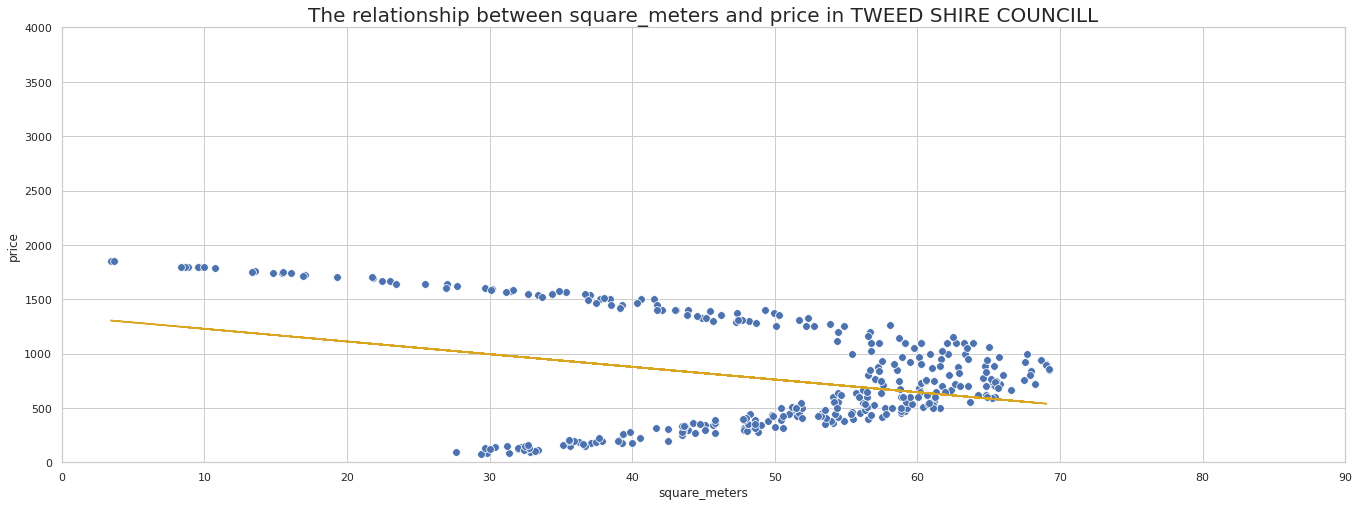

In [0]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = australia_df_coucil3, s=60)
plt.plot(X3_test, listing_y3_pred, color='goldenrod')
plt.xlim([0,90])
plt.ylim([0,4000])
plt.title('The relationship between square_meters and price in TWEED SHIRE COUNCILL',fontsize = 20)

According to the plot we see, the dataset is not fit the regression, maybe we can divide the dataset into more specific area to change a model to analyze.

#Part 5 - We could add more variables to change a model to train to get another possible model.#

In [0]:
X_cols4 = ['square_meters', 'bathrooms', 'beds']

#Load the X data set
X4 = australia_df_coucil1[X_cols4].values

#Initialize the data and column length variables
data_length4 = len(australia_df_coucil1)
column_length4 = len(australia_df_coucil1[X_cols4].columns)

#Reshape and load remaining data sets
X4 = X4.reshape(data_length4,column_length4)
y4 = australia_df_coucil1['price'].values
y4 = y4.reshape(data_length4,1)

#Split the data into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4)

#Create the linear regression object and train/fit models
lin_reg4= LinearRegression()
lin_reg4.fit(X4_train, y4_train)

#Make predictions using the testing set
listing_y4_pred = lin_reg4.predict(X4_test)

##Take the results from above and print out a few pieces of information##

In [0]:
#Print a few predictions
print((pd.DataFrame(listing_y4_pred, columns={'y4_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg4.intercept_))

#Print the coefficient(s)
coeff_df4 = pd.DataFrame(lin_reg4.coef_)
coeff_df4.columns = X_cols4
print(coeff_df4)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y4_test, listing_y4_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y4_test, listing_y4_pred))

   y4_prediction
0     739.415612
1    1606.974261
2     113.802250
3     389.299172
4     512.030703

Intercept: -1117.1888230523111
   square_meters   bathrooms       beds
0      46.036328  192.226053 -18.091617

Mean Squared Error (MSE):63102.43
Variance Score (R^2):0.90


### *The result of MSE decrease and R ^ 2 more possible equals to 1. so the beds, bedrooms, square meter all can be related to price.

## Summary: 
1.The area in  Ballina shire council combining with beds, bathrooms, bedromms data is most comfortable providing pricing recommendations, since the MSE is 63102, which is minimum value among these analysis and Variance Score is 0.9, which approximatley equals to 1. As a result, this area is the most comfortable recommendations.

2.The area in TWEED SHIRE COUNCILL is least comfortable providing pricing recommendations, since MSE is 204022 and variance Score is 0.08, and the variance score is approximately equals to 0, which shows that the training does not help at all.

3.According to the model we have tried, it seems like the dataset after filter is not really available to analyze, maybe we should divide the dataset more specifically or we could add a few more variable to see whether the other variable will effect the result.

#Part 6- Hypothesis Testing#
## Data Acquisition and Simple Exploration##

In [0]:
#Read data from Google Sheet
SFO_data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRpqI2_Obvg4fJYXViTiKFqlWx33FBKg9fD_h8bLUs7CYonXrEHiRqnid47jWhrWkiOlWbVqVMBBNh4/pub?output=csv"
LAX_data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRFh1dHf1DgS-9e8opQpHrMJcf3hwJUOTDeFEjy8L32bto-z34Nds0uq3sNYNeWZ9BVXlSITTZv_l97/pub?output=csv"
SFO_df = pd.read_csv(SFO_data_path)
LAX_df = pd.read_csv(LAX_data_path)

In [0]:
SFO_df.head()

,Date,SFO - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
0,09/14/2019,88.066066,0
1,09/15/2019,56.019054,0
2,09/16/2019,40.766571,0
3,09/17/2019,67.544491,0
4,09/18/2019,57.562244,0


In [0]:
LAX_df.head()

,Date,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
0,09/14/2019,40.077684,0
1,09/15/2019,125.733874,0
2,09/16/2019,62.949019,0
3,09/17/2019,119.277093,0
4,09/18/2019,59.340067,0


##Column Definitions:
* Date - The date that the observation was recorded.
* Avg. Daily Miles Driven Per Hour - The amount of average daily miles driven on average per hour.
* Marketing_Campaign - A binary field that is set to either 1 for when the markteting campaign were held or 0 for when the markteting campaign not held.

In [0]:
list(SFO_df)

['Date', 'SFO - Avg. Daily Miles Driven Per Hour', 'Marketing_Campaign']

##Test Setup:Hypothesis
* The Null  is that the amount of average daily miles driven when the marketing campaign was held is the same as the amount of average daily miles driven **when tmarketing campaign was not held**.

* The Alternate Hypothesis is that the amount of average daily miles driven when the marketing campaign is held  not equal the amount of average daily miles driven **when tthe marketing campaign is not held.**
* The p-value will be set to 0.05

## Marketing Campaign Quantitative Variable Overview - SFO##

In [0]:
SFO_df.describe()

,SFO - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,103.000000,103.000000
mean,57.080330,0.281553
std,31.445346,0.451956
min,3.992414,0.000000
25%,39.610922,0.000000
50%,60.899223,0.000000
75%,78.312594,1.000000
max,126.266381,1.000000


## plot a histogram to explore the distribution of average daily miles driven.

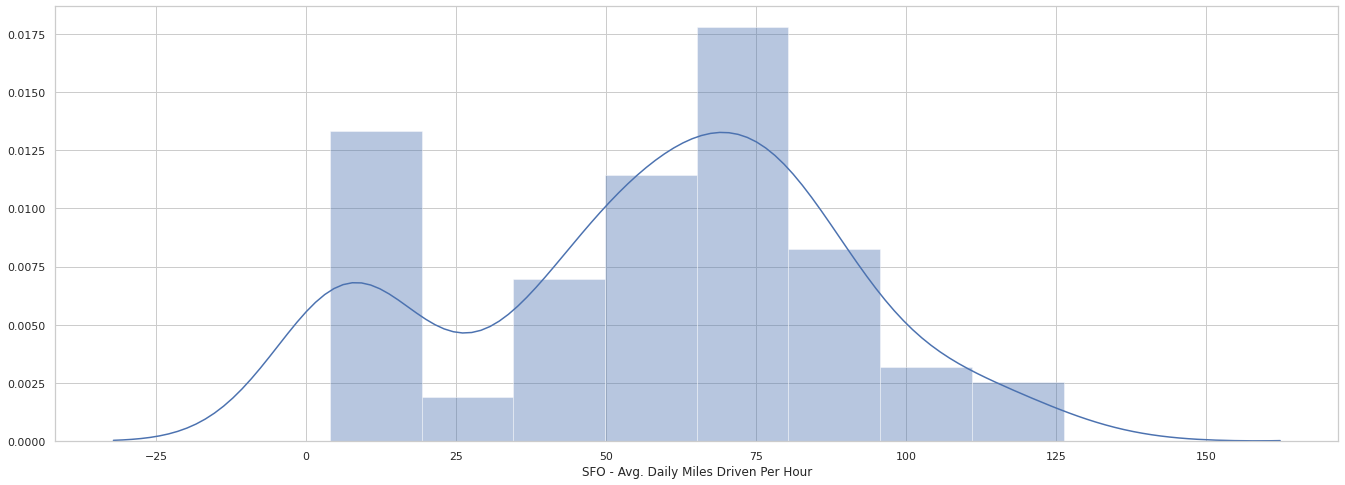

In [0]:
sns.set_style('whitegrid')
plt.figure(figsize=(23,8))
sns.set(style='whitegrid')
ax = sns.distplot(SFO_df['SFO - Avg. Daily Miles Driven Per Hour'], bins = 8)

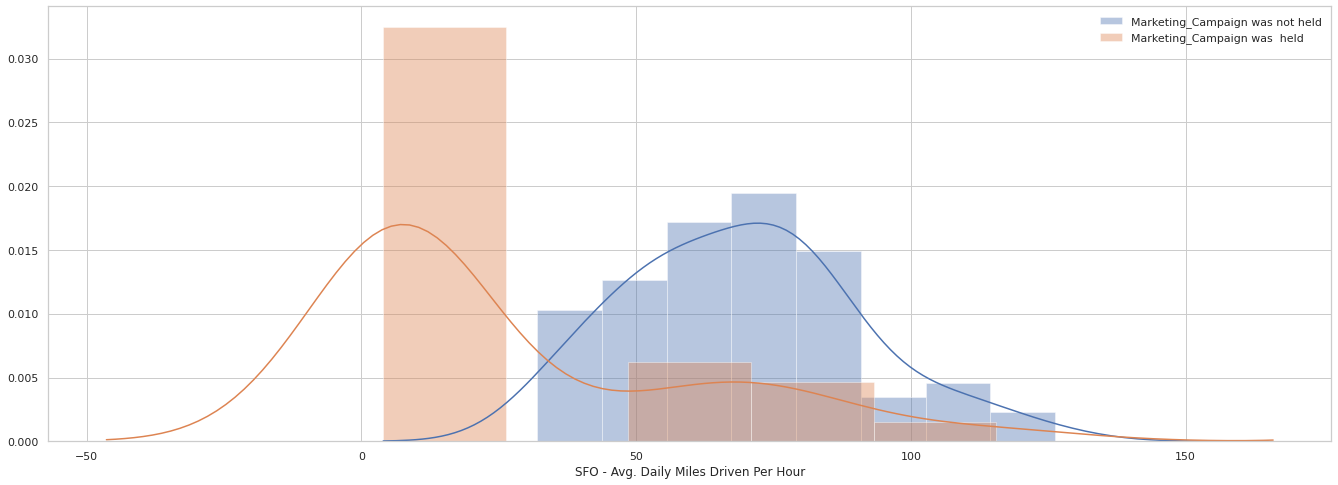

In [0]:
data0 = SFO_df['SFO - Avg. Daily Miles Driven Per Hour'].loc[SFO_df['Marketing_Campaign']==0]
data1 = SFO_df['SFO - Avg. Daily Miles Driven Per Hour'].loc[SFO_df['Marketing_Campaign']==1]

sns.set_style('whitegrid')
plt.figure(figsize=(23,8))
sns.set(style='whitegrid')
ax = sns.distplot(data0, hist=True)
ax = sns.distplot(data1, hist=True)
plt.legend(['Marketing_Campaign was not held','Marketing_Campaign was  held'])

In [0]:
data0.describe()

count     74.000000
mean      69.367157
std       21.127243
min       31.965430
25%       53.257416
50%       68.116384
75%       81.383748
max      126.266381
Name: SFO - Avg. Daily Miles Driven Per Hour, dtype: float64

In [0]:
data1.describe()

count     29.000000
mean      25.727736
std       31.957688
min        3.992414
25%        6.733449
50%        8.195329
75%       48.709683
max      115.530706
Name: SFO - Avg. Daily Miles Driven Per Hour, dtype: float64

In [0]:
# Analysis of Variance test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import f_oneway

#generate three independent samples
data0 = SFO_df['SFO - Avg. Daily Miles Driven Per Hour'].loc[SFO_df['Marketing_Campaign']==0]
data1 = SFO_df['SFO - Avg. Daily Miles Driven Per Hour'].loc[SFO_df['Marketing_Campaign']==1]

#compare samples
stat, p = f_oneway(data0, data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=65.503, p=0.000
Different distributions (reject H0)


### Since the p =0 is less than alpha = 0.05, the decision is to reject the null hypothesis. Summarize the results. There is enough evidence to support the claim that the amount of average daily miles driven when the marketing campaign was held is the same as the amount of average daily miles driven when tmarketing campaign was not held.

### Also, comparing data0 with data1, the mean(data0) > mean(data1), so **the dataset in SFO shows that marketing campaign decrease the average iles driven per Uber driver**. 

## Marketing Campaign Quantitative Variable Overview - LAX##

In [0]:
LAX_df.describe()

,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,103.000000,103.000000
mean,128.359637,0.291262
std,67.114355,0.456566
min,-14.680382,0.000000
25%,75.778773,0.000000
50%,122.768415,0.000000
75%,172.795002,1.000000
max,299.004450,1.000000


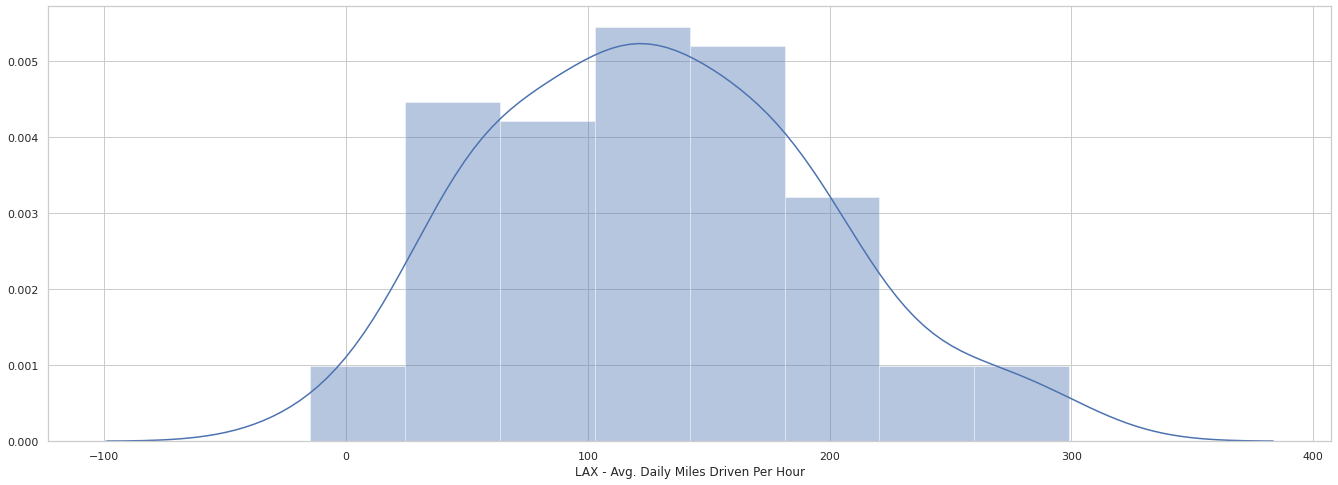

In [0]:
sns.set_style('whitegrid')
plt.figure(figsize=(23,8))
sns.set(style='whitegrid')
ax = sns.distplot(LAX_df['LAX - Avg. Daily Miles Driven Per Hour'], bins = 8)

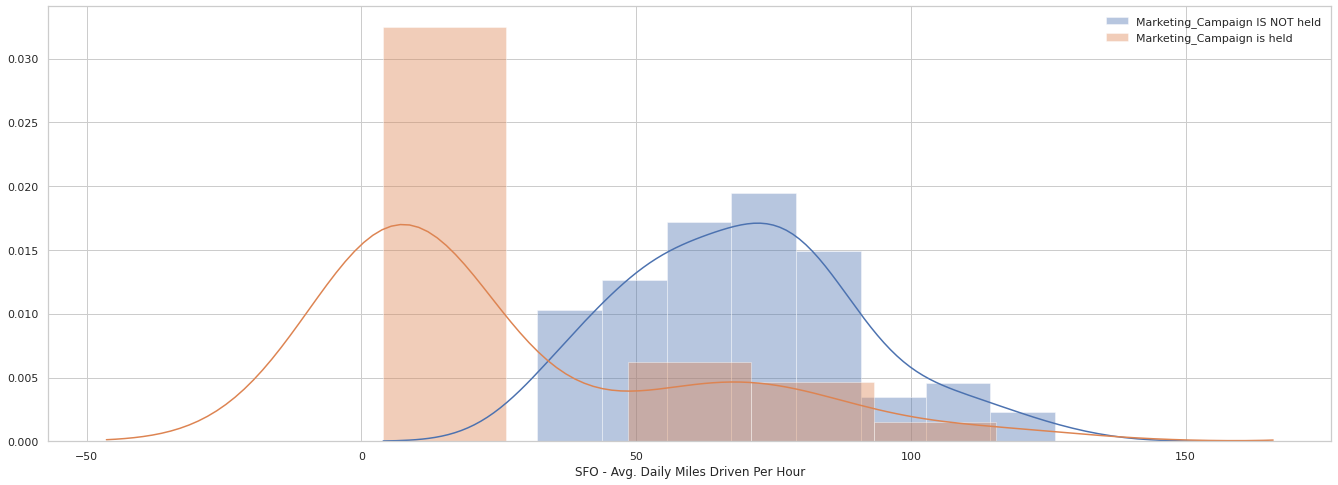

In [0]:
data2 = LAX_df['LAX - Avg. Daily Miles Driven Per Hour'].loc[LAX_df['Marketing_Campaign']==0]
data3 = LAX_df['LAX - Avg. Daily Miles Driven Per Hour'].loc[LAX_df['Marketing_Campaign']==1]

sns.set_style('whitegrid')
plt.figure(figsize=(23,8))
sns.set(style='whitegrid')
ax = sns.distplot(data0, hist=True)
ax = sns.distplot(data1, hist=True)
plt.legend(['Marketing_Campaign IS NOT held','Marketing_Campaign is held'])

In [0]:
data2.describe()

count     73.000000
mean     108.822783
std       56.565693
min      -14.680382
25%       62.949019
50%      111.789765
75%      152.605945
max      254.650582
Name: LAX - Avg. Daily Miles Driven Per Hour, dtype: float64

In [0]:
data3.describe()

count     30.000000
mean     175.899314
std       67.823719
min       44.757042
25%      123.280002
50%      189.178298
75%      211.374968
max      299.004450
Name: LAX - Avg. Daily Miles Driven Per Hour, dtype: float64

In [0]:
# Analysis of Variance test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import f_oneway

#generate three independent samples
data2 = LAX_df['LAX - Avg. Daily Miles Driven Per Hour'].loc[LAX_df['Marketing_Campaign']==0]
data3 = LAX_df['LAX - Avg. Daily Miles Driven Per Hour'].loc[LAX_df['Marketing_Campaign']==1]

#compare samples
stat, p = f_oneway(data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=26.560, p=0.000
Different distributions (reject H0)


### Since the p =0 is less than alpha = 0.05, the decision is to reject the null hypothesis. Summarize the results. There is enough evidence to support the claim that the amount of average daily miles driven when the marketing campaign was held is the same as the amount of average daily miles driven when tmarketing campaign was not held.

### Also, comparing data2 with data3, the mean(data2) < mean(data3), so **the dataset in LAX shows that marketing campaign raise the average iles driven per Uber driver**. 